If looking at token representations layer by layer, do clusters of "ideas" start to form? Perhaps the individual tokens group up into words, then phrases, then concepts.

Authors: Oscar Skean

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import tqdm

import repitl.matrix_itl as itl
from utils.misc.model_dataloader_utils import embed_sentences_and_get_outputs, reduce_and_visualize_hidden_states
from utils.misc.metric_utils import get_model_path, get_dataloader

device = "cuda:1"

ImportError: cannot import name 'get_model_path' from 'utils.misc.metric_utils' (/home/AD/ofsk222/Research/exploration/information_plane/experiments/utils/misc/metric_utils.py)

In [2]:
# load model and dataset
model_path = get_model_path("EleutherAI", "410m")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to(device)

dataloader = get_dataloader(tokenizer, "wikitext", split="train", num_samples=25000, filter_text_columns=False)

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Encode sentence from wikitext and checkout the representations per layer

In [3]:
# get hidden states for one sentence
with torch.no_grad():
    for idx, batch in enumerate(tqdm.tqdm(dataloader)):
        sentence = batch.pop("text")
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        hidden_states = outputs.hidden_states

        print(idx, len(batch["input_ids"][0]))

        if idx >= 33:
            break

  0%|          | 0/11621 [00:00<?, ?it/s]

  0%|          | 6/11621 [00:00<17:07, 11.30it/s]  

0 71
1 170
2 68
3 195
4 131
5 117
6 61
7 63
8 76


  0%|          | 16/11621 [00:00<07:31, 25.71it/s]

9 143
10 10
11 213
12 162
13 147
14 18
15 223
16 28
17 25


  0%|          | 26/11621 [00:01<05:36, 34.42it/s]

18 9
19 237
20 96
21 153
22 102
23 82
24 49
25 52
26 181
27 9


  0%|          | 33/11621 [00:01<07:38, 25.27it/s]

28 206
29 212
30 86
31 31
32 168
33 256


In [8]:
print("===========SENTENCE=============")
print(sentence[0])

print("===========TOKENS=============")
for idx, tok in enumerate(batch["input_ids"][0]):
    print(idx, tokenizer.decode(tok.item()))

===========SENTENCE=============
 Young specimens of A. hygrometricus have roughly spherical fruit bodies that typically start their development partially embedded in the substrate . A smooth whitish mycelial layer covers the fruit body , and may be partially encrusted with debris . As the fruit body matures , the mycelial layer tears away , and the outer tissue layer , the exoperidium , breaks open in a star @-@ shaped ( stellate ) pattern to form 4 – 20 irregular " rays " . This simultaneously pushes the fruit body above ground to reveal a round spore case enclosed in a thin papery endoperidium . The rays open and close in response to levels of moisture in the environment , opening up in high humidity , and closing when the air is dry . This is possible because the exoperidium is made of several different layers of tissue ; the innermost , fibrous layer is hygroscopic , and curls or <unk> the entire ray as it loses or gains moisture from its surroundings . This adaptation enables the

NUM LAYERS 25


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


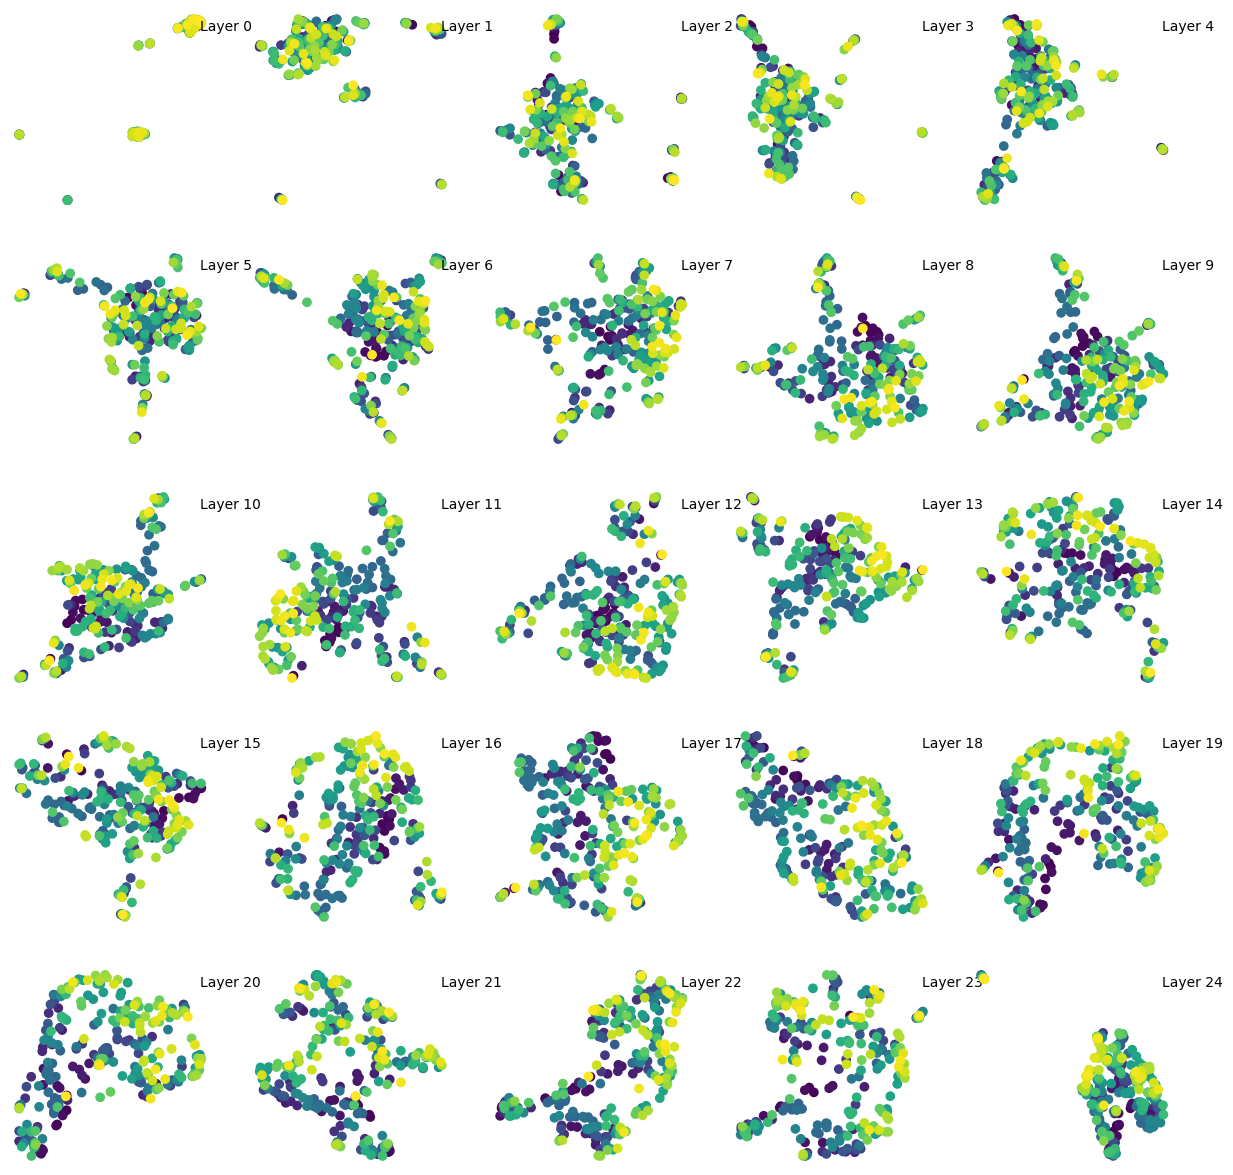

In [14]:
tsne_hidden_states = reduce_and_visualize_hidden_states(hidden_states, reduction="umap")

## Investigating Distinct Clusters

There seems to be some strong clusterization going on in the middle layers. Let's take a look at what tokens are forming the clusters

/tmp/ipykernel_2940986/3658732488.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_res[chosen_indices, 0], tsne_res[chosen_indices, 1], c="red", cmap="viridis")


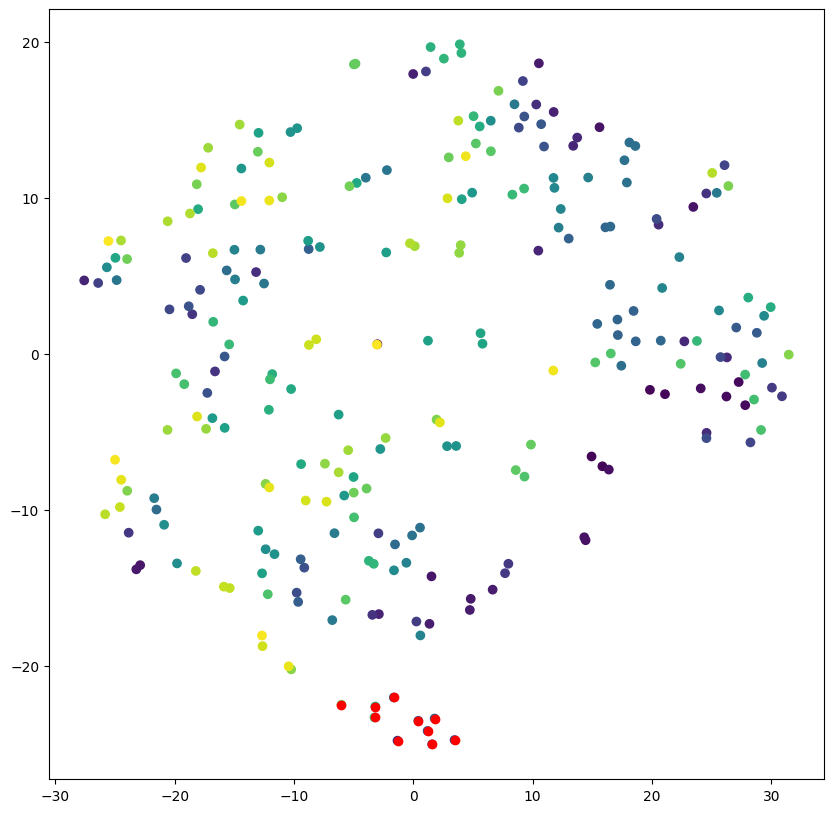

In [6]:
# plot layer 5 specifically
fig, ax = plt.subplots(figsize=(10, 10))
layer = 23

tsne_res = tsne_results_by_layer[layer]

# get points within specifie bounds
x_threshold_left = -8
x_threshold_right = 10000
y_threshold_top = -20
y_threshold_bottom = -10000

chosen_indices = np.where((tsne_res[:, 0] > x_threshold_left) & 
                          (tsne_res[:, 0] < x_threshold_right) & 
                          (tsne_res[:, 1] > y_threshold_bottom) & 
                          (tsne_res[:, 1] < y_threshold_top))[0]


colors = np.array(list(range(num_tokens)))
ax.scatter(tsne_res[:, 0], tsne_res[:, 1], c=colors, cmap="viridis")
ax.scatter(tsne_res[chosen_indices, 0], tsne_res[chosen_indices, 1], c="red", cmap="viridis")


/tmp/ipykernel_2940986/1776483411.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row][col].scatter(tsne_results[chosen_indices, 0], tsne_results[chosen_indices, 1], c="red", cmap="viridis")


Text(0.5, 0.98, ' layer| body| layer| tissue layer|idium,|idium| layer| adaptation')

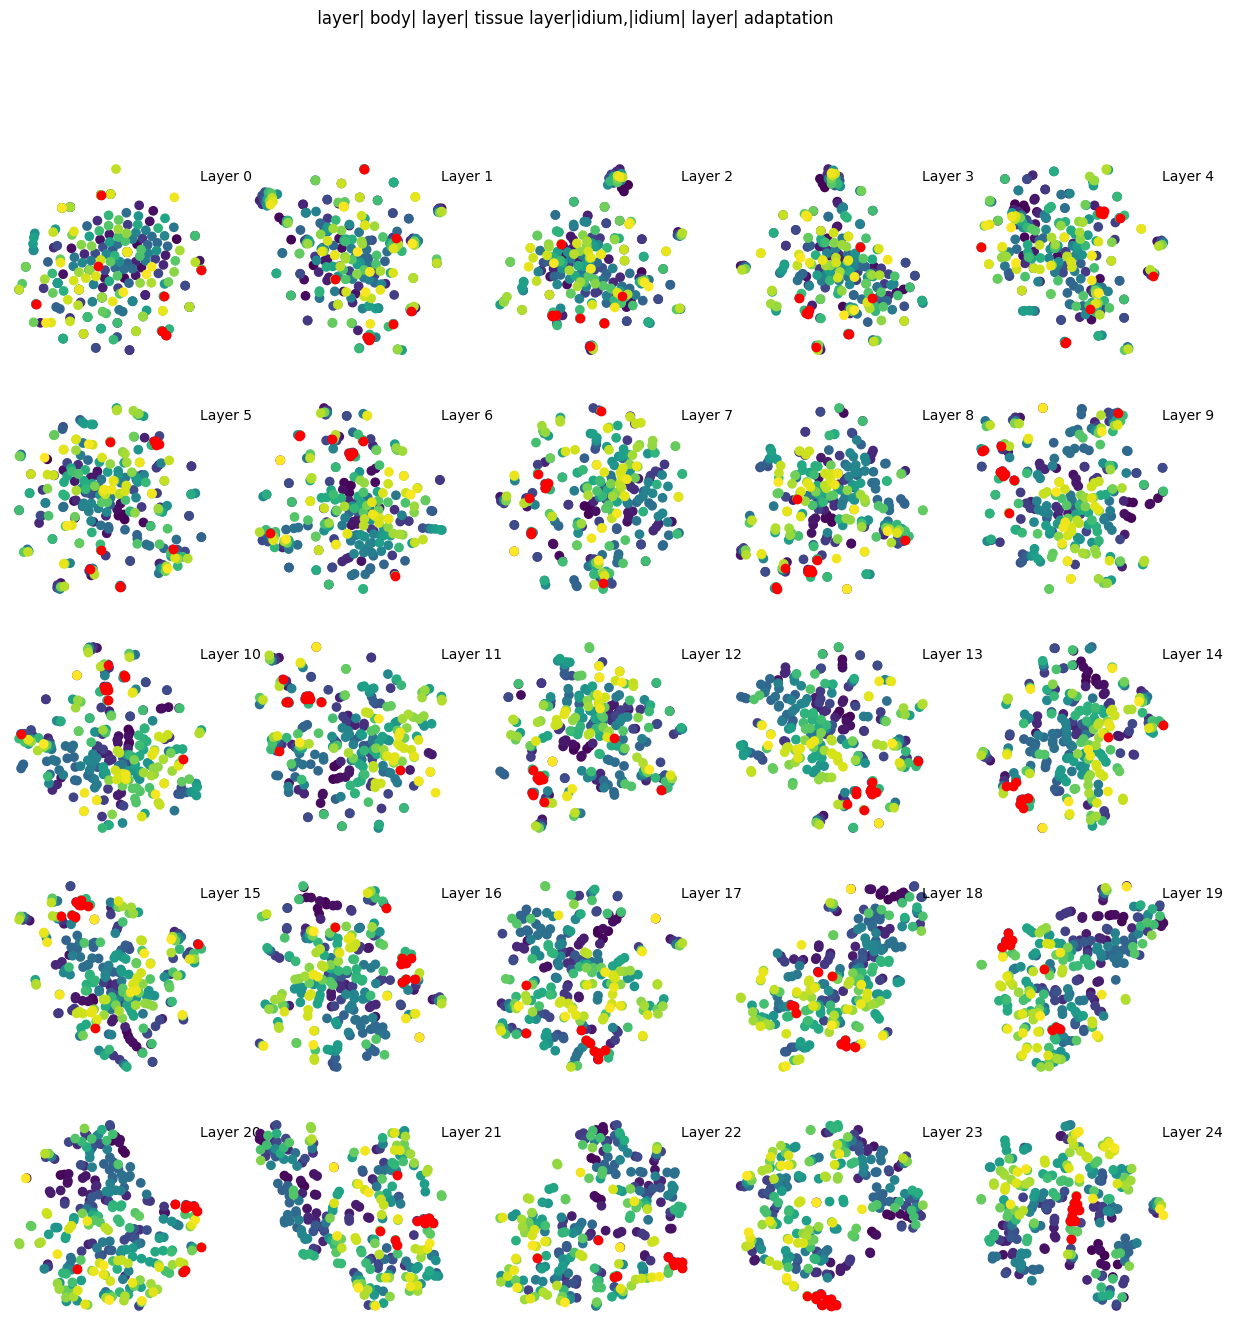

In [7]:
# plot the chosen points in ALL layers
# uses same TNSE from before for consistency

fig, axs = plt.subplots(num_rows, layers_per_row, figsize=(15, 3*num_rows))
for i in range(num_layers):
    row, col = divmod(i, layers_per_row)

    layer_hidden_states = hidden_states[i].squeeze().cpu().numpy()

  
    tsne_results = tsne_results_by_layer[i]

    colors = np.array(list(range(num_tokens)))
    axs[row][col].scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, cmap="viridis")
    axs[row][col].scatter(tsne_results[chosen_indices, 0], tsne_results[chosen_indices, 1], c="red", cmap="viridis")

    # put row number in corner
    axs[row][col].text(0.95, 0.95, f"Layer {i}", transform=axs[row][col].transAxes, ha="left", va="top")
    axs[row][col].axis("off")

# hide empty plots
for i in range(num_layers, num_rows*layers_per_row):
    row, col = divmod(i, layers_per_row)
    axs[row][col].axis("off")


# make the selected tokens the sup title
tokens = [(chosen_indices[idx], tokenizer.decode(tok.item())) for idx, tok in enumerate(batch["input_ids"][0][chosen_indices])]
combined = []
for idx, tok in tokens:
    if combined and idx == combined[-1][0] + 1:
        combined[-1] = (idx, combined[-1][1] + tok, 1)
    else:
        combined.append((idx, tok, 0))

fig_title = "|".join([x[1] for x in combined])
fig.suptitle(fig_title)

# Manual Cluster Labelling

The above section is good for finding clusters one at a time. This section makes it easier to store manual labels and use for clusters.

In [8]:
cluster_data = [
    # {   "name": "punctuation",
    #     "bounds":(-10000, 10000, 21, 10000),
    #     "layer": 10
    # },
    {   "name": "'the'",
        "bounds":(-10000, 10000, 21, 10000),
        "layer": 2
    },
    {   "name": "'.'",
        "bounds": (26, 10000, -10000, 10000),
        "layer": 24
    },
    {   "name": "','",
        "bounds": (5, 20, 15, 10000),
        "layer": 16
    },
    {   "name": "'specimens of A. hygrometricus have roughly'",
        "bounds": (-15, -2, 17, 10000),
        "layer": 16
    },
    {
        "name": "'fruit'",
        "bounds": (22, 10000, 10, 20),
        "layer": 17
    },
    {
        "name": "prepositions",
        "bounds": (1, 10, -10000, -20),
        "layer": 21
    },
    {
        "name": "prep. phrase",
        "bounds": (-10000, -5, -10000, -20),
        "layer": 18
    },
    {
        "name": "rel. environment",
        "bounds": (13, 25, 4, 13),
        "layer": 24
    }
]

# find and add indices for cluster_data
for cluster in cluster_data:
    x_threshold_left, x_threshold_right, y_threshold_bottom, y_threshold_top = cluster["bounds"]
    layer = cluster["layer"]

    tsne_res = tsne_results_by_layer[layer]
    chosen_indices = np.where((tsne_res[:, 0] > x_threshold_left) & 
                              (tsne_res[:, 0] < x_threshold_right) & 
                              (tsne_res[:, 1] > y_threshold_bottom) & 
                              (tsne_res[:, 1] < y_threshold_top))[0]

    cluster["indices"] = chosen_indices
    cluster["tokens"] = [(chosen_indices[idx], tokenizer.decode(tok.item())) for idx, tok in enumerate(batch["input_ids"][0][chosen_indices])]

In [9]:
for cluster in cluster_data:
    print(cluster["name"], cluster["tokens"])

'the' [(0, ' Young'), (1, ' specimens'), (2, ' of'), (23, ' the'), (35, ' the'), (50, ' the'), (56, ' the'), (65, ' the'), (70, ' the'), (102, ' the'), (124, ' The'), (136, ' the'), (148, ' the'), (157, ' the'), (170, ' the'), (188, ' the'), (204, ' the'), (230, ' the'), (240, ' the'), (249, ' the')]
'.' [(25, '.'), (48, '.'), (98, '.'), (123, '.'), (152, '.'), (200, '.'), (223, '.'), (254, '.'), (255, ' \n')]
',' [(38, ','), (63, ','), (69, ','), (74, ','), (138, ','), (144, ','), (173, ','), (180, ','), (216, ','), (242, ',')]
'specimens of A. hygrometricus have roughly' [(1, ' specimens'), (2, ' of'), (3, ' A'), (4, '.'), (5, ' hy'), (6, 'g'), (7, 'rom'), (8, 'etric'), (9, 'us'), (10, ' have'), (11, ' roughly'), (177, ' hy'), (178, 'g')]
'fruit' [(13, ' fruit'), (36, ' fruit'), (51, ' fruit'), (103, ' fruit'), (205, ' fruit'), (227, ' fruit')]
prepositions [(49, ' As'), (105, ' above'), (115, ' in'), (135, ' in'), (147, ' when'), (156, ' because'), (191, ' as'), (211, ' at'), (224, 

Text(0.5, 0.98, 'Manually Identified Clusters')

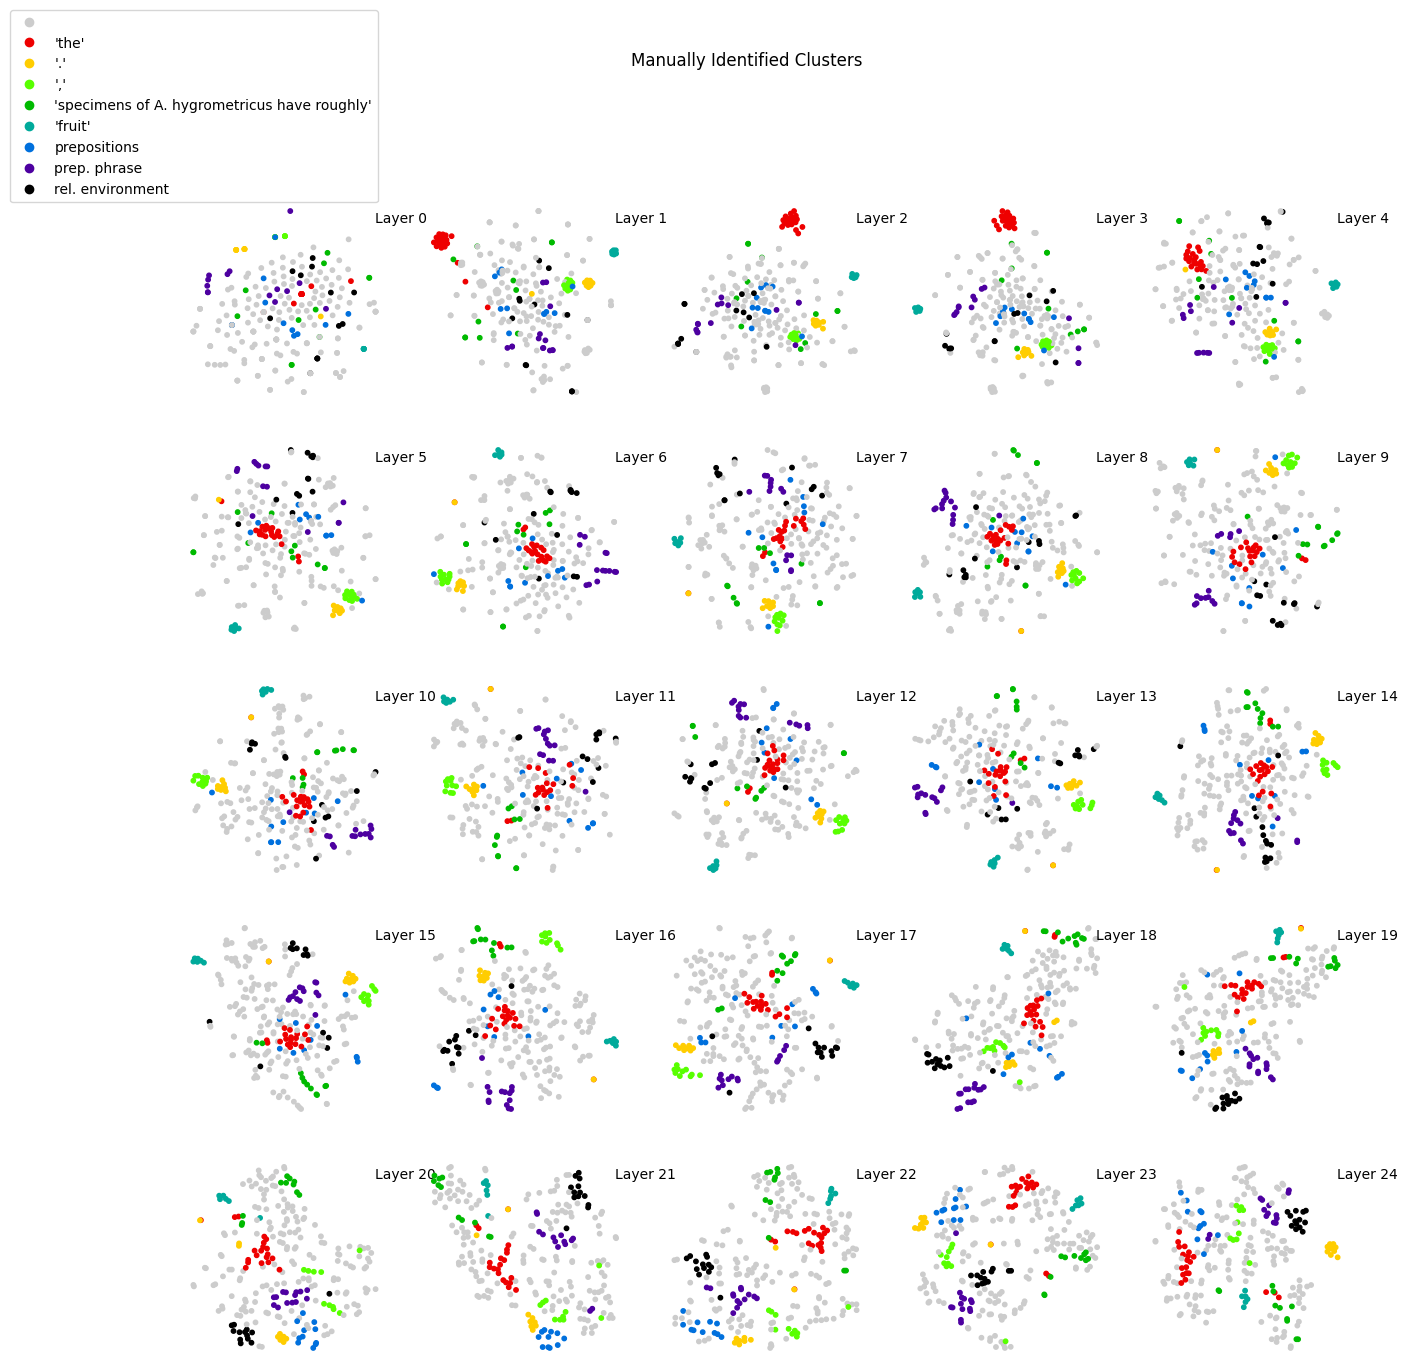

In [10]:
# create a label list for each point based on cluster
labels = []
legend_labels = [" "] + [cluster["name"] for cluster in cluster_data]
for i in range(num_tokens):
    label = 0
    legend = "None"
    for idx, cluster in enumerate(cluster_data):
        if i in cluster["indices"]:
            label = 1+idx
            break
    labels.append(label)

# plot the clusters over ALL layers
fig, axs = plt.subplots(num_rows, layers_per_row, figsize=(15, 3*num_rows))
for i in range(num_layers):
    row, col = divmod(i, layers_per_row)

    tsne_results = tsne_results_by_layer[i]
    scatter = axs[row][col].scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="nipy_spectral_r", s=10)


    # put row number in corner
    axs[row][col].text(0.95, 0.95, f"Layer {i}", transform=axs[row][col].transAxes, ha="left", va="top")
    axs[row][col].axis("off")

# hide empty plots
for i in range(num_layers, num_rows*layers_per_row):
    row, col = divmod(i, layers_per_row)
    axs[row][col].axis("off")

axs[0][0].legend(handles=scatter.legend_elements()[0], labels=legend_labels, bbox_to_anchor=(1, 2),)

fig.suptitle("Manually Identified Clusters")

# Embedding synonyms with made up words

In [48]:
from utils import embed_sentences_and_get_outputs

# TODO: there is some paper i saw before that used made up words to train a transformer. 
# I think the usecase was articial language supervision for an image encoder ViT.
# would be interesting to find and revisit

sentence = """1) The quick brown fox jumps over the lazy dog.
2) I am a sentence that is not in the training data.
3) You can't be serious, can you?
4) This is the fourth item in the list.
5) Alfredo and Johnny opened the door and walked in.
6) The cat in the hat sat on the mat.
7) Oscar is typing on his computer.
"""
outputs = embed_sentences_and_get_outputs(model, tokenizer, sentence)

In [49]:
# make classes for item in the list
num_classes = sentence.count("\n")

# split outputs.input_ids by \n token
newline_token = tokenizer.encode("\n")[0]
newline_locations = [idx for idx, tok in enumerate(outputs.input_ids[0]) if tok == newline_token]
print(newline_locations)
labels = [0] * (newline_locations[0]+1)
for idx in range(1, num_classes):
    labels.extend([idx] * (newline_locations[idx] - newline_locations[idx-1]))

[12, 27, 39, 51, 65, 78, 88]


In [50]:
print(len(outputs["input_ids"][0]), len(labels))

89 89


NUM LAYERS 25


100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


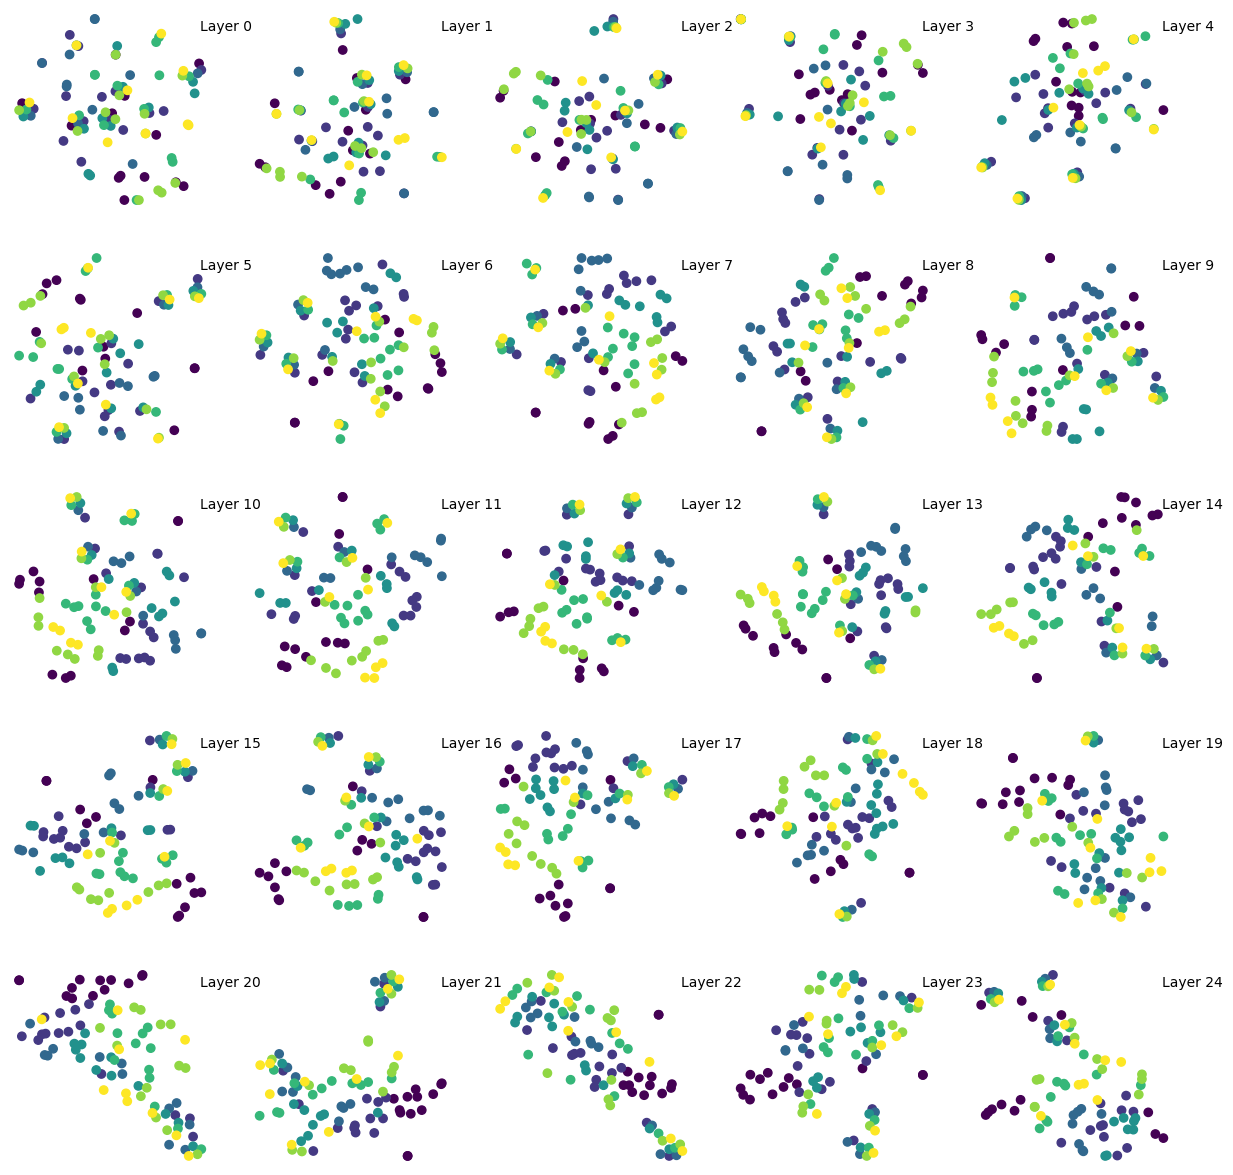

In [54]:
reduced_hidden_states = reduce_and_visualize_hidden_states(outputs["hidden_states"], reduction="tsne", labels=labels)